## L-mode H-mode  Classifier

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import confinement_mode_classifier as cmc
from datetime import datetime
import time 
import torchvision
import torch
from torch.optim import lr_scheduler
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

Seed set to 42


Device: cuda:0


In [11]:
path = Path(os.getcwd())
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
batch_size = 32
shots = [16534, 16769, 16773, 18130, 19237, 19240, 19379, 18057, 16989]
shots_for_testing = [16769, 18130, 18057]
shots_for_validation = [19237]

shot_df, test_df, val_df, train_df = cmc.load_and_split_dataframes(path,shots, shots_for_testing, shots_for_validation )


test_dataloader = cmc.get_dloader(test_df, path=path, batch_size=batch_size)
val_dataloader = cmc.get_dloader(val_df, path=path, batch_size=batch_size)
train_dataloader = cmc.get_dloader(train_df, path=path, batch_size=batch_size)

### Create dataloader, that will be used in training

In [5]:
dataloaders = {'train':train_dataloader, 'val':val_dataloader}
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}

In [6]:
timestamp =  datetime.fromtimestamp(time.time()).strftime("%d-%m-%Y, %H-%M-%S ") + input('add comment: ')

# create grid of images
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f'runs/{timestamp}')

## Import ResNet pretrained model
### And freeze all layers except last f.c. layer


In [7]:
pretrained_model = torchvision.models.resnet18(weights='IMAGENET1K_V1', )
for param in pretrained_model.parameters():
    param.requires_grad = False
 
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_ftrs, 3) #3 classes: L-mode, H-mode, ELM
pretrained_model = pretrained_model.to(device)

### Hyperparameters

In [8]:
#
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(pretrained_model.parameters(), lr=0.001) #pouzit adam

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

## Train last fc of the model

In [9]:
num_epochs = 2
model = cmc.train_model(pretrained_model, criterion, optimizer, exp_lr_scheduler, 
                        dataloaders, writer, dataset_sizes, num_epochs=num_epochs, comment = 'fc training')
model_path = Path(f'{path}/runs/{timestamp}/model_fc_trained.pt')
torch.save(model.state_dict(), model_path)

Epoch 1/2
----------


  0%|          | 0/280 [00:00<?, ?it/s]

train Loss: 0.3125 Acc: 0.8932


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.1585 Acc: 0.9636

Epoch 2/2
----------


  0%|          | 0/280 [00:00<?, ?it/s]

train Loss: 0.1350 Acc: 0.9662


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.1214 Acc: 0.9682

Training complete in 5m 27s
Best val Acc: 0.968238


### Test model with last fc trained

0it [00:00, ?it/s]

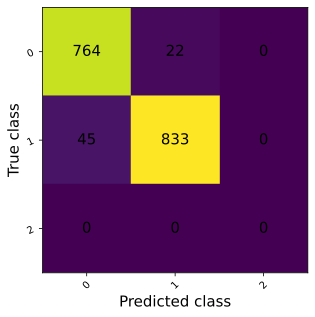

In [18]:
_, fig_confusion_matrix, f1, precision, recall, accuracy = cmc.test_model(model, test_dataloader, max_batch=50, return_metrics=True)

writer.add_figure(f'Confusion matrix for the model with trained f.c. layer', fig_confusion_matrix)
writer.add_scalar(f'Accuracy on test_dataset with trained f.c. layer', accuracy)
writer.add_scalar(f'F1 metric on test_dataset with trained f.c. layer', f1)
writer.add_scalar(f'Precision on test_dataset with trained f.c. layer', precision)
writer.add_scalar(f'Recall on test_dataset with trained f.c. layer', recall)
writer.close()

## Train the whole model

In [ ]:
for param in model.parameters():
    param.requires_grad = True
model = cmc.train_model(pretrained_model, criterion, optimizer, exp_lr_scheduler, 
                        dataloaders, writer, dataset_sizes, num_epochs=num_epochs, comment = 'fc training')
model_path = Path(f'{path}/runs/{timestamp}/model_fully_trained.pt')
torch.save(model.state_dict(), model_path)

### Test model with all layers trained

In [ ]:
_, fig_confusion_matrix, f1, precision, recall, accuracy = cmc.test_model(model, test_dataloader, max_batch=50, return_metrics=True)

writer.add_figure(f'Confusion matrix for the model with all layers trained', fig_confusion_matrix)
writer.add_scalar(f'Accuracy on test_dataset with all layers trained', accuracy)
writer.add_scalar(f'F1 metric on test_dataset with all layers trained', f1)
writer.add_scalar(f'Precision on test_dataset with all layers trained', precision)
writer.add_scalar(f'Recall on test_dataset with all layers trained', recall)
writer.close()